In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

sns.set_theme()

In [2]:
df = pd.read_csv("../datasets/TrueFX/EURUSD-2024-02/EURUSD-2024-02.csv", header=None)
df.columns = ['Pair', 'TimeStamp', 'Bid', 'Ask']
df = df[['TimeStamp', 'Bid', 'Ask']]
df['TimeStamp'] = pd.to_datetime(df['TimeStamp']) - pd.Timedelta(hours=5) # turn GMT to EST time

In [118]:
df['Date'] = df['TimeStamp'].dt.date
df['Time'] = df['TimeStamp'].dt.time
df['Hour'] = df['TimeStamp'].dt.hour
df['Minute'] = df['TimeStamp'].dt.minute
df['Second'] = df['TimeStamp'].dt.second

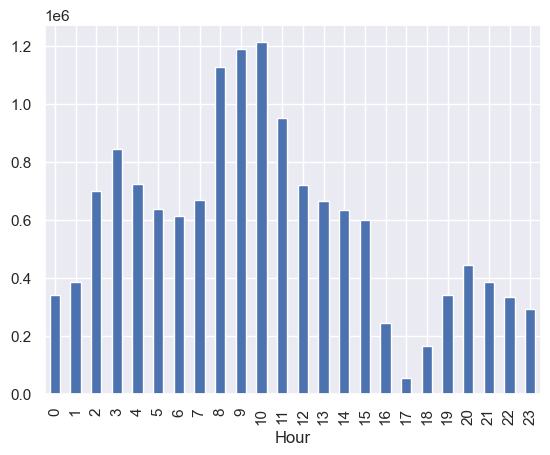

In [121]:
df.groupby('Hour').size().plot(kind='bar')
plt.show()

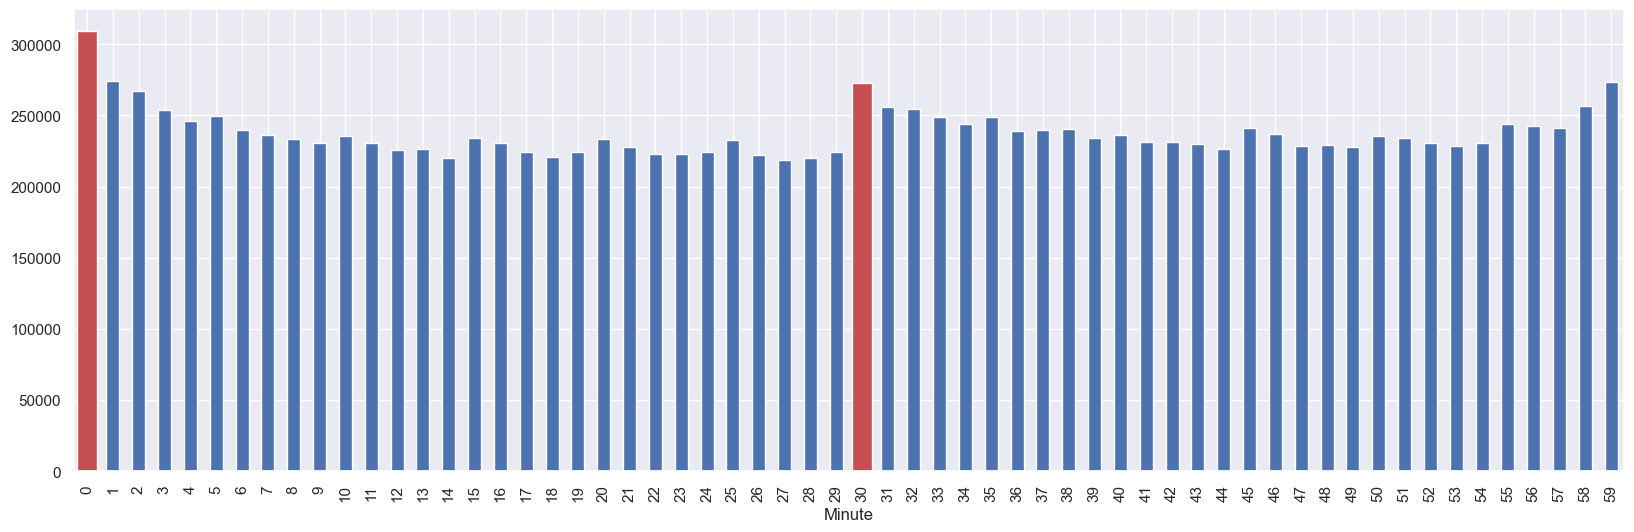

In [274]:
plt.figure(figsize=(20, 6))
df.groupby('Minute').size().plot(kind='bar')
plt.bar([0, 30], df.groupby('Minute').size().loc[[0, 30]], color='r')
plt.show()

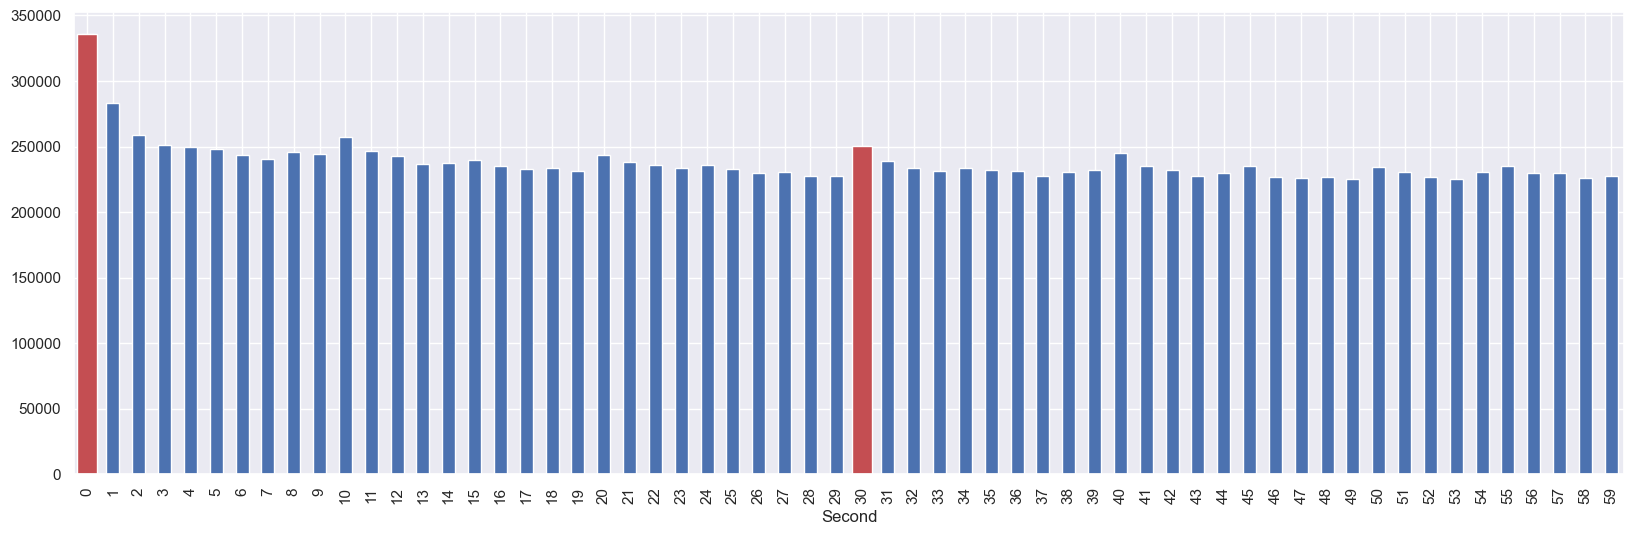

In [275]:
plt.figure(figsize=(20, 6))
df.groupby('Second').size().plot(kind='bar')
plt.bar([0, 30], df.groupby('Second').size().loc[[0, 30]], color='r')
plt.show()

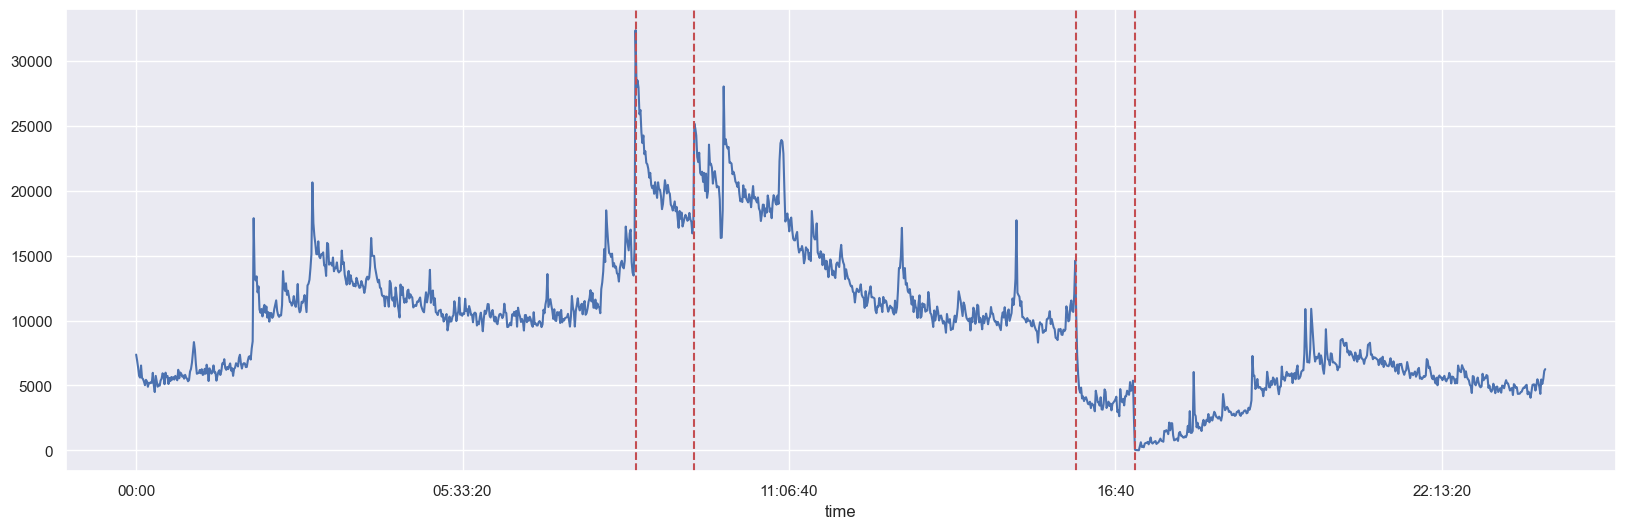

In [276]:
x = df.groupby(['Hour', 'Minute']).size()
x.index = x.index.map(lambda x: f"{x[0]}:{x[1]}")
x.index = pd.to_datetime(x.index, format='%H:%M').time
plt.figure(figsize=(20, 6))
x.plot()
plt.axvline(x='08:30', color='r', linestyle='--')
plt.axvline(x='09:30', color='r', linestyle='--')
plt.axvline(x='16:00', color='r', linestyle='--')
plt.axvline(x='17:00', color='r', linestyle='--')
plt.show()

In [197]:
chosen_date = pd.to_datetime('2024-02-01').date()
sub_df = df[df['Date'] == chosen_date]
sub_df

,TimeStamp,Bid,Ask,Date,Time,Mid,Spread,Hour,Minute,Second
105729,2024-02-01 00:00:00.029,1.08073,1.08082,2024-02-01,00:00:00.029000,1.080775,0.00009,0,0,0
105730,2024-02-01 00:00:00.108,1.08076,1.08079,2024-02-01,00:00:00.108000,1.080775,0.00003,0,0,0
105731,2024-02-01 00:00:00.154,1.08073,1.08081,2024-02-01,00:00:00.154000,1.080770,0.00008,0,0,0
105732,2024-02-01 00:00:00.201,1.08072,1.08080,2024-02-01,00:00:00.201000,1.080760,0.00008,0,0,0
105733,2024-02-01 00:00:00.217,1.08074,1.08079,2024-02-01,00:00:00.217000,1.080765,0.00005,0,0,0
...,...,...,...,...,...,...,...,...,...,...
912442,2024-02-01 23:59:59.171,1.08731,1.08731,2024-02-01,23:59:59.171000,1.087310,0.00000,23,59,59
912443,2024-02-01 23:59:59.577,1.08726,1.08734,2024-02-01,23:59:59.577000,1.087300,0.00008,23,59,59
912444,2024-02-01 23:59:59.608,1.08727,1.08735,2024-02-01,23:59:59.608000,1.087310,0.00008,23,59,59
912445,2024-02-01 23:59:59.608,1.08731,1.08731,2024-02-01,23:59:59.608000,1.087310,0.00000,23,59,59


In [283]:
# taus = [f'{100*i}ms' for i in range(1,10)] + [f'{i}s' for i in range(1,10)] + [f'{10*i}s' for i in range(1,6)] + [f'{i}min' for i in range(1,11)]
taus = [f'{100*i}ms' for i in range(1,101)]
C_first = []
C_mean = []
C_last = []
T = sub_df['TimeStamp'].iloc[-1] - sub_df['TimeStamp'].iloc[0]

for tau in taus:
    N = T.total_seconds() / pd.to_timedelta(tau).total_seconds() # number of intervals
    # resampled_sub_df = sub_df.resample(tau, on='TimeStamp').first().ffill()
    resampled_mid_first = sub_df.resample(tau, on='TimeStamp')['Mid'].first().ffill()
    resampled_mid_mean = sub_df.resample(tau, on='TimeStamp')['Mid'].mean().ffill()
    resampled_mid_last = sub_df.resample(tau, on='TimeStamp')['Mid'].last().ffill()
    qv_first = ((resampled_mid_first.diff())**2).sum() # quadratic variation
    qv_mean = ((resampled_mid_mean.diff())**2).sum()
    qv_last = ((resampled_mid_last.diff())**2).sum()
    C_first.append(qv_first)
    C_mean.append(qv_mean)
    C_last.append(qv_last)

In [284]:
df_first = pd.DataFrame({'tau': taus, 'C': C_first})
df_first['tau'] = pd.to_timedelta(df_first['tau']).dt.total_seconds()
df_mean = pd.DataFrame({'tau': taus, 'C': C_mean})
df_mean['tau'] = pd.to_timedelta(df_mean['tau']).dt.total_seconds()
df_last = pd.DataFrame({'tau': taus, 'C': C_last})
df_last['tau'] = pd.to_timedelta(df_last['tau']).dt.total_seconds()

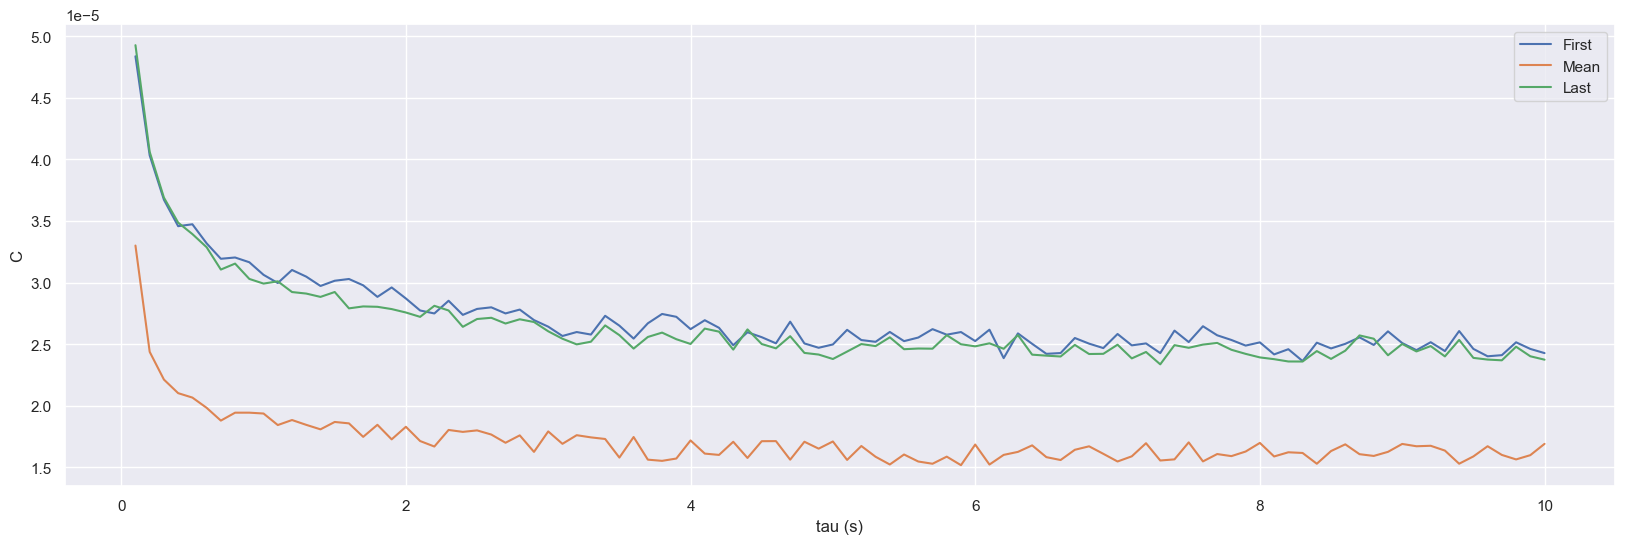

In [290]:
# plot
plt.figure(figsize=(20, 6))
plt.plot(df_first['tau'], df_first['C'], label='First')
plt.plot(df_mean['tau'], df_mean['C'], label='Mean')
plt.plot(df_last['tau'], df_last['C'], label='Last')
plt.xlabel('tau (s)')
plt.ylabel('C')
plt.legend()
plt.show()

If prices followed a brownian motion we would have a flat plot...

Let's instead model: $dX(t) = dN_+(t) - dN_-(t)$ i.e. $X(t)=N_+(t)-N_-(t)$.

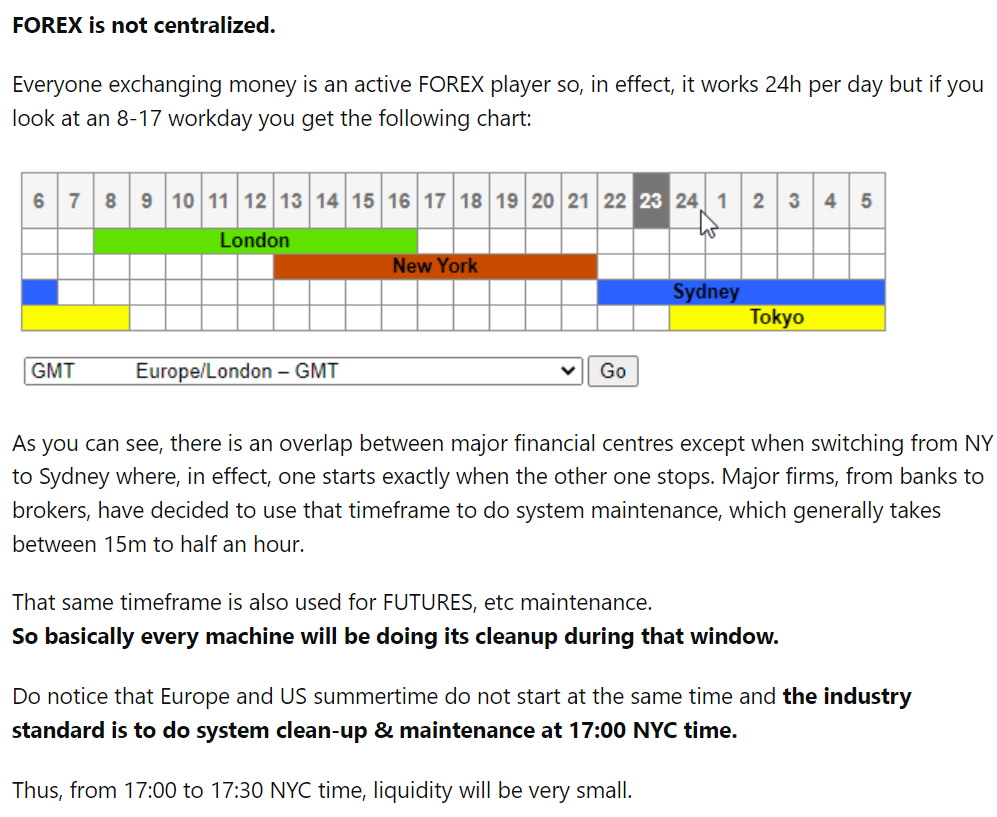

In [31]:
oneday['hour'] = oneday['TimeStamp'].dt.hour
oneday['minute'] = oneday['TimeStamp'].dt.minute
oneday['second'] = oneday['TimeStamp'].dt.second

C:\Users\gecre\AppData\Local\Temp\ipykernel_2796\2371151526.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  oneday['hour'] = oneday['TimeStamp'].dt.hour
C:\Users\gecre\AppData\Local\Temp\ipykernel_2796\2371151526.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  oneday['minute'] = oneday['TimeStamp'].dt.minute
C:\Users\gecre\AppData\Local\Temp\ipykernel_2796\2371151526.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_index

<Axes: title={'center': 'Number of ticks per hour for EURUSD on 2024-02-01'}, xlabel='Hour', ylabel='Number of ticks'>

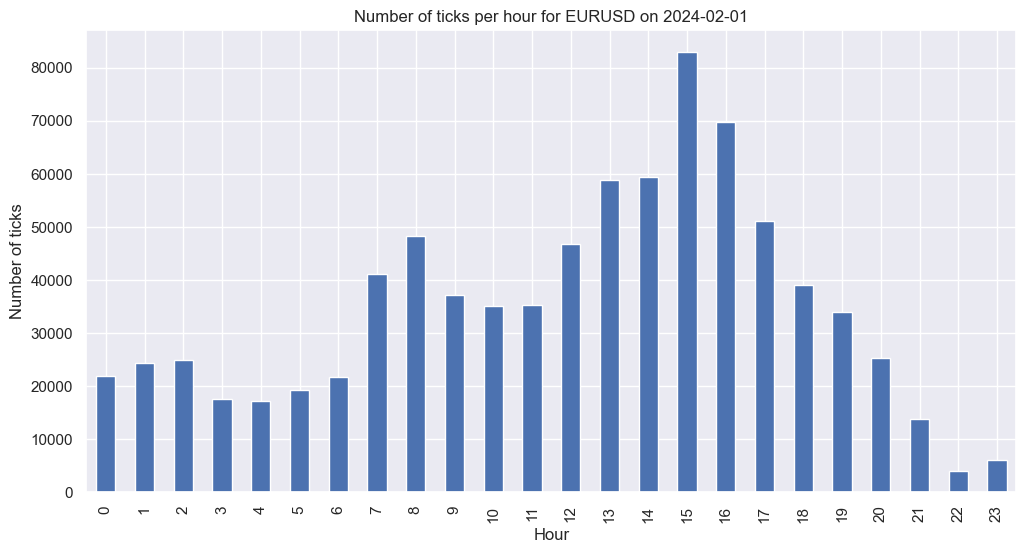

In [33]:
oneday.groupby('hour').size().plot(kind='bar', xlabel='Hour', ylabel='Number of ticks', title='Number of ticks per hour for EURUSD on 2024-02-01', figsize=(12, 6))

<Axes: title={'center': 'Number of ticks per minute for EURUSD on 2024-02-01'}, xlabel='Minute', ylabel='Number of ticks'>

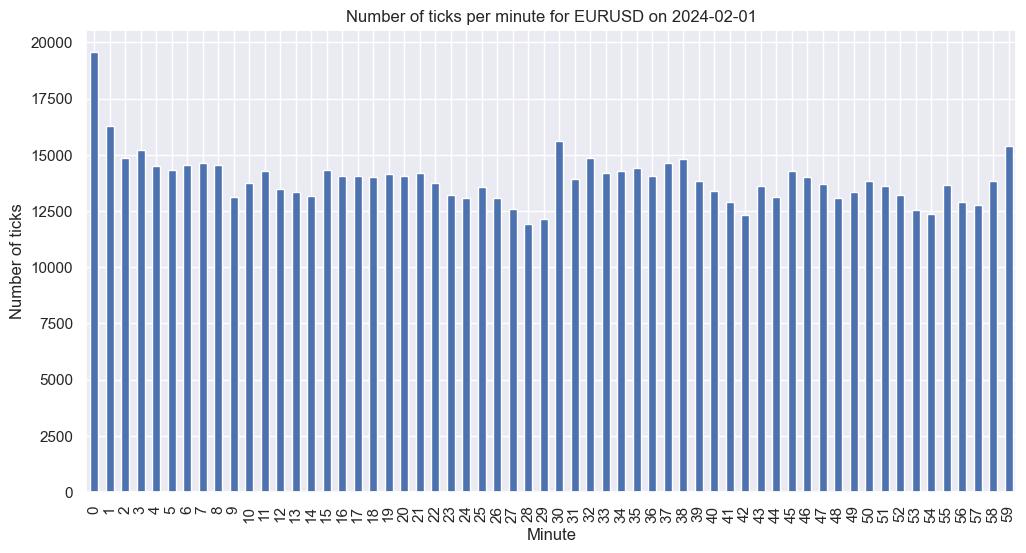

In [40]:
oneday.groupby('minute').size().plot(kind='bar', xlabel='Minute', ylabel='Number of ticks', title='Number of ticks per minute for EURUSD on 2024-02-01', figsize=(12, 6))

<Axes: title={'center': 'Number of ticks per second for EURUSD on 2024-02-01'}, xlabel='Second', ylabel='Number of ticks'>

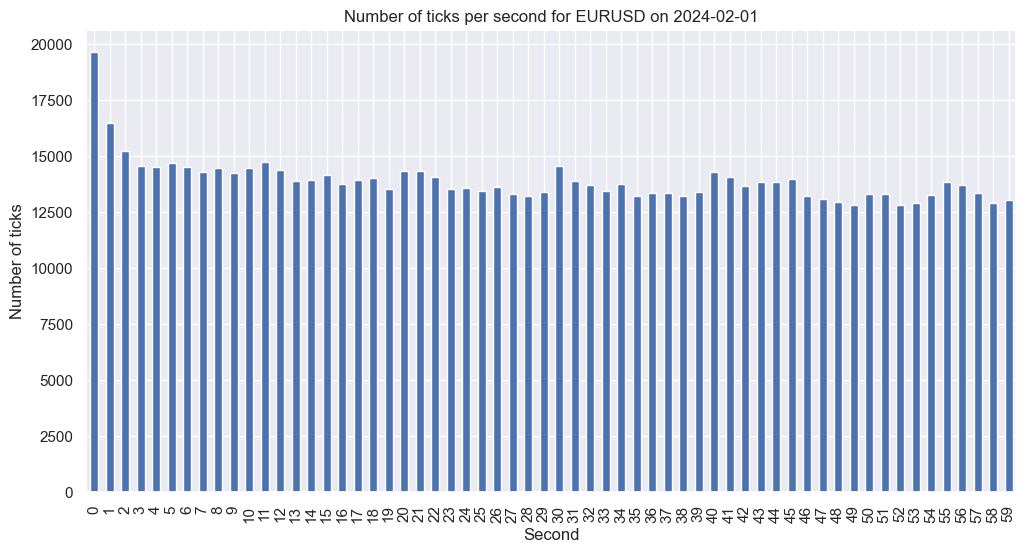

In [39]:
oneday.groupby('second').size().plot(kind='bar', xlabel='Second', ylabel='Number of ticks', title='Number of ticks per second for EURUSD on 2024-02-01', figsize=(12, 6))

In [60]:
oneday['TimeStamp'].diff().argmax()

824301

In [61]:
oneday.iloc[oneday['TimeStamp'].diff().argmax() - 1:oneday['TimeStamp'].diff().argmax() + 2]

,TimeStamp,Bid,Ask,Date,Time,hour,minute,second
824300,2024-02-01 22:00:00.065,1.08704,1.08751,2024-02-01,22:00:00.065000,22,0,0
824301,2024-02-01 22:06:35.974,1.08703,1.08734,2024-02-01,22:06:35.974000,22,6,35
824302,2024-02-01 22:06:44.726,1.08703,1.08735,2024-02-01,22:06:44.726000,22,6,44


In [57]:
oneday

,TimeStamp,Bid,Ask,Date,Time,hour,minute,second
0,2024-02-01 00:00:00.080,1.08036,1.08043,2024-02-01,00:00:00.080000,0,0,0
1,2024-02-01 00:00:00.205,1.08037,1.08043,2024-02-01,00:00:00.205000,0,0,0
2,2024-02-01 00:00:00.236,1.08036,1.08043,2024-02-01,00:00:00.236000,0,0,0
3,2024-02-01 00:00:00.643,1.08036,1.08042,2024-02-01,00:00:00.643000,0,0,0
4,2024-02-01 00:00:00.643,1.08036,1.08043,2024-02-01,00:00:00.643000,0,0,0
...,...,...,...,...,...,...,...,...
834283,2024-02-01 23:59:59.084,1.08741,1.08746,2024-02-01,23:59:59.084000,23,59,59
834284,2024-02-01 23:59:59.225,1.08739,1.08747,2024-02-01,23:59:59.225000,23,59,59
834285,2024-02-01 23:59:59.303,1.08741,1.08746,2024-02-01,23:59:59.303000,23,59,59
834286,2024-02-01 23:59:59.600,1.08739,1.08747,2024-02-01,23:59:59.600000,23,59,59


In [77]:
df['Mid'] = (df['Bid'] + df['Ask']) / 2
df['Spread'] = df['Ask'] - df['Bid']

In [94]:
#set x == 22h GTM
x = pd.to_datetime('2024-02-01 22:00:00')

In [95]:
SYSTEM_CHANGE = {
    # 22h GMT for Monday
    'Monday': pd.to_datetime('22:00:00', utc=True).tz_convert('GMT'),
    'Tuesday': pd.to_datetime('22:00:00', utc=True).tz_convert('GMT'),
    'Wednesday': pd.to_datetime('22:00:00', utc=True).tz_convert('GMT'),
    'Thursday': pd.to_datetime('22:00:00', utc=True).tz_convert('GMT'),
    'Friday': pd.to_datetime('22:00:00', utc=True).tz_convert('GMT'),
    'Saturday': None,
    'Sunday': pd.to_datetime('22:00:00', utc=True).tz_convert('GMT'),
}

# every day at 5pm NY time (22h GMT), banks will shift work to Sydney but since there is no overlap they use the time to update their systems, takes 15-30min, hence the spread increase

Thus, small liquity from 5pm NYC to ~5:30pm NYC.

KeyError: 'hour'

<Figure size 1200x600 with 0 Axes>

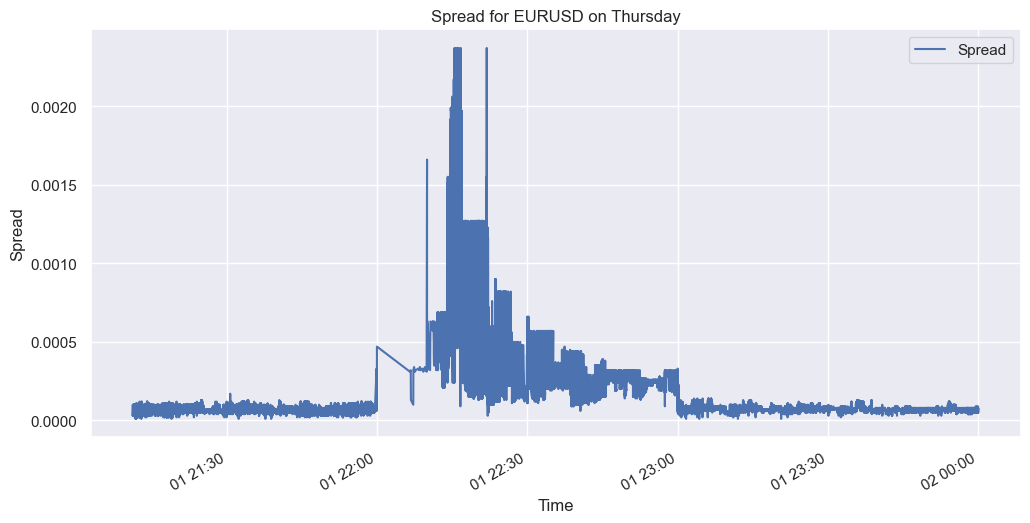

In [110]:
days = df['Date'].unique()

for day in days:
    plt.figure(figsize=(12, 6))
    df_oneday = df[df['Date'] == day]
    # print time of the largest time difference between two consecutive ticks
    largest_tick_diff = df_oneday['TimeStamp'].diff().argmax()
    time_largest_tick_diff = df_oneday['TimeStamp'].iloc[largest_tick_diff]
    window_left = 10000
    window_right = 10000
    day_name = pd.to_datetime(day).strftime('%A')
    sub_df = df_oneday.iloc[largest_tick_diff - window_left:largest_tick_diff + window_right]
    sub_df.plot(x='TimeStamp', y='Spread', xlabel='Time', ylabel='Spread', title=f'Spread for EURUSD on {day_name}', figsize=(12, 6))
    sub_df.groupby(['hour', 'minute']).size().plot(kind='bar')
    plt.axvline(x=time_largest_tick_diff, color='r', linestyle='--')
    plt.show()

In [112]:
df

,TimeStamp,Bid,Ask,Date,Time,Mid,Spread
0,2024-02-01 00:00:00.080,1.08036,1.08043,2024-02-01,00:00:00.080000,1.080395,0.00007
1,2024-02-01 00:00:00.205,1.08037,1.08043,2024-02-01,00:00:00.205000,1.080400,0.00006
2,2024-02-01 00:00:00.236,1.08036,1.08043,2024-02-01,00:00:00.236000,1.080395,0.00007
3,2024-02-01 00:00:00.643,1.08036,1.08042,2024-02-01,00:00:00.643000,1.080390,0.00006
4,2024-02-01 00:00:00.643,1.08036,1.08043,2024-02-01,00:00:00.643000,1.080395,0.00007
...,...,...,...,...,...,...,...
14272966,2024-02-29 23:59:59.104,1.08052,1.08062,2024-02-29,23:59:59.104000,1.080570,0.00010
14272967,2024-02-29 23:59:59.135,1.08055,1.08059,2024-02-29,23:59:59.135000,1.080570,0.00004
14272968,2024-02-29 23:59:59.229,1.08052,1.08062,2024-02-29,23:59:59.229000,1.080570,0.00010
14272969,2024-02-29 23:59:59.244,1.08055,1.08059,2024-02-29,23:59:59.244000,1.080570,0.00004
